# Implementing Regression Discontinuity Design in R
### by [Jason DeBacker](http://jasondebacker.com), October 2019

This notebook provides an example of an regression discontinuity design in R.  With this example, the notebook will show some of the plotting capabilties of the `ggplot` library for R.

## Example: Lee (*Journal of Econometrics*, 2008)

[Lee (2008)](https://www.princeton.edu/~davidlee/wp/RDrand.pdf) seeks to answer an empirical question - how big is the incumbency advantage in the U.S. House? - and provide a methodological contribution - can we use regression discontinuity design to identify causal effects if the running variable is endogenous?

Economists and political scientists have studied the incumbency advantage for decades.  The main empirical challenge here is obvious: incumbents are from a selected sample - they were elected to office in the first place!  So simply looking at the rate at which incumbents win elections doesn't tell you anything about the causal impact of incumbency on elections.  Rather, it could just be evidence that good candidates do better than poorer candidates.  There have been a number of interesting approaches to tackle this problem, including [Levitt (*Journal of Political Economy*, 1994)](http://pricetheory.uchicago.edu/levitt/Papers/LevittUsingRepeatChallengers1994.pdf) who uses elections where the challenging candidate is the same.

Lee's important idea: let's look at close elections.  These could have gone either way, so the candidates who were running were of similar quality, but one just one.  And that narrow victor of the election at time $t$ now has the advantage of incumbency at $t+1$.  So we should be able to identify the incumbency advantage by looking at how candidates who narrowly won the election at time $t$ perform at time $t+1$.  More specifically, Lee (2008) looks at the incumbency advantage accruing to the party (and not to a specific candidate).  But the idea is the same (and in fact, since most incumbents run again, the effects on the party and the individual and quantitatively similar as well).

We'll replicate Lee's analysis here.  To begin, I've downloaded the Election Table data from the the ICPSR's [Database of United States Congressional Historical Statistics](http://www.icpsr.umich.edu/icpsrweb/ICPSR/studies/3371?q=congressional+election) as a Stata datafile, renamed `Election_Data.dta` and placed it in `./data/`.

With these data we won't have all the elections considered by Lee (2008) and so won't be able to replicate his analysis exactly, but these are close enough.

We'll need to do a bit of cleaning to these data.  Let's load the libraries we neeed and do the cleaning first.

### Cleaning data

In [1]:
# install packages we'll use - if not already installed
install.packages(c("haven", "dplyr", "reshape2", "data.table",
                   "DataCombine", "Hmisc", "rdd", "ggplot2"))
# Import libaries used in this notebook
x <- c("haven", "dplyr", "reshape2", "data.table", "DataCombine",
       "Hmisc", "rdd", "ggplot2")
lapply(x, FUN = function(X) {
    do.call("require", list(X)) 
})


  There is a binary version available but the source version is later:
           binary source needs_compilation
data.table 1.12.2 1.12.4              TRUE


The downloaded binary packages are in
	/var/folders/b0/wwxd0byd1hx0y_rqrnqhmc0m0000gn/T//RtmpoAZJXR/downloaded_packages


installing the source package ‘data.table’

Loading required package: haven
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: reshape2
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:reshape2’:

    dcast, melt

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: DataCombine

Attaching package: ‘DataCombine’

The following object is masked from ‘package:data.table’:

    shift

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

In [3]:
# read in data from ./data/Election_Data.dta
df <- read_dta("./data/Election_Data.dta")
# make all variable names lower case
df <- setNames(df, tolower(names(df)))

# clean election data
# keep only years 1946+ and House general elections
elec_data <- subset(df, year >= 1946 & electype == "G" & office == 3)
# keep only columns will use
elec_data <- elec_data[,c("cand_id","year","congress", "state", "district", "candpct", "party", "outcome", "incumb")]

### Setup data for analysis

Create dataset on candidates:
1. Number of election wins prior to year t
2. Number of elections campaigned in prior to year t

In [4]:
# sort by year
df <- df[order(df$year),]
# create indicator if ran in election
df["ran_for_office"] <- 1
# create electoral experience by summing previous times ran for office
cand_data <- mutate(group_by(df,cand_id), elec_experience=cumsum(ran_for_office) - 1) # minus 1 so don't count current election
# create political experience by number of general elections previously won
# Note: we'll just count congress since in these data - if doing this for real might want to include state offices
# create political experience by finding number of wins at time t
cand_data <- subset(cand_data, electype == "G") # wins only in general elections
cand_data <- cand_data[order(cand_data$year),]
cand_data <- mutate(group_by(cand_data,cand_id), pol_experience=cumsum(outcome))
cand_data["pol_experience"] <- cand_data["pol_experience"] - cand_data["outcome"] # so don't count current election outcome
# keep only columns of interest
cand_data <- cand_data[,c("cand_id","year","elec_experience", "pol_experience")]

Finally, get candidate and election characteristics together and get in shape for RD.  We want something with one row per election (not per candidate).

In [5]:
# merge new candidate data to elections data
rd_data <- merge(elec_data, cand_data, by.x=c("cand_id", "year"), by.y=c("cand_id", "year"), all=FALSE)

# rank by percent of vote share (with in each race)
rd_data <- mutate(group_by(rd_data, .dots=c("congress","state","district")),
                  ranking=rank(-candpct, ties.method = 'first'))

# keep only top 2 per race
rd_data <- subset(rd_data, ranking < 3)

# drop cand_id
rd_data <- subset(rd_data, select = -c(cand_id))

# reshape data to wide - so one row per race
rd_wide <- as.data.frame(dcast(setDT(rd_data), congress + year + state + district ~ ranking,
                               value.var = c("candpct", "party", "outcome", "incumb",
                                             "elec_experience", "pol_experience")))

# create variables for democratic winner and democratic vote share
rd_wide$dem_win <- ifelse((rd_wide$party_1 == 100) & (rd_wide$outcome_1 == 1), 1, 0)
rd_wide$dem_share <- ifelse((rd_wide$party_1 == 100), rd_wide$candpct_1,
                            ifelse(rd_wide$party_2 == 100, rd_wide$candpct_2, 0))

# Create variable for Democratic margin of victory.  This will be running variable in RDD
# set to missing if dem if isn't one of two parties in top 2
rd_wide$margin <- ifelse((rd_wide$party_1 == 100), rd_wide$candpct_1 - rd_wide$candpct_2,
                         ifelse(rd_wide$party_2 == 100, rd_wide$candpct_2 - rd_wide$candpct_1, NA))

# Create variables for Democratic candidate experience
rd_wide$dem_elec_exp <- ifelse((rd_wide$party_1 == 100), rd_wide$elec_experience_1,
                         ifelse(rd_wide$party_2 == 100, rd_wide$elec_experience_2, NA))
rd_wide$dem_pol_exp <- ifelse((rd_wide$party_1 == 100), rd_wide$pol_experience_1,
                         ifelse(rd_wide$party_2 == 100, rd_wide$pol_experience_2, NA))

# drop obs with missing values for margin
rd_wide <- rd_wide[!(is.na(rd_wide$margin) | rd_wide$margin==""), ]
# drop those where margin is 0, but candidate shares are above 51 pct
# I don't know what such a case could be but there are about 400 in the data
rd_wide <- rd_wide[!(rd_wide$margin==0 & rd_wide$candpct_1 > 51), ]

# Create leads and lags of vote share and wins
rd_wide <- rd_wide[with(rd_wide, order(state, district, congress)), ]
# create leads for dem win and dem vote share
rd_wide <- slide(rd_wide, Var = "dem_win",  NewVar = 'dem_win_p1', GroupVar = c("state", "district"),
                    slideBy = 1)
rd_wide <- slide(rd_wide, Var = "dem_share", NewVar = 'dem_share_p1', GroupVar = c("state", "district"),
                    slideBy = 1)
rd_wide <- slide(rd_wide, Var = "dem_win", NewVar = 'dem_win_m1', GroupVar = c("state", "district"),
                    slideBy = -1)
rd_wide <- slide(rd_wide, Var = "dem_share", NewVar = 'dem_share_m1', GroupVar = c("state", "district"),
                    slideBy = -1)
rd_wide <- rd_wide[with(rd_wide, order(state, district, congress)), ]

# drop if missing values for leads (e.g. if year > 1986)
rd_wide <- subset(rd_wide, year < 1987)


Remember to order rd_wide by state and the time variable before running.
Remember to order rd_wide by district and the time variable before running.

Leading dem_win by 1 time units.


Remember to order rd_wide by state and the time variable before running.
Remember to order rd_wide by district and the time variable before running.

Leading dem_share by 1 time units.


Remember to order rd_wide by state and the time variable before running.
Remember to order rd_wide by district and the time variable before running.

Lagging dem_win by 1 time units.


Remember to order rd_wide by state and the time variable before running.
Remember to order rd_wide by district and the time variable before running.

Lagging dem_share by 1 time units.



Now our data is all in order and ready for analysis.  

Regression discontinuity design is an approach that is well represented with visuals.  So before we even discuss the econometics, let's just take a look at the data to see if we notice anything near those close elections.

We have a few thousand election in our dataset, so just plotting the results of all of them will be a bit noisy.  Instead, we'll group our data into bins based on the margin of victory for the Democrat candidate in the election at time $t$.  We can then compute the probability that a Democrat wins the district at time $t+1$ and the vote share of the Democrat candidate at time $t+1$ for each of these bins.

In the block of code that follows, we create bins for every 2 percentage points of the margin of victory for the Democrat at time $t$ and then compute means for several variables within these groups.  We put these "bin-level" observations in a new data frame called `binned_data`. 

In [6]:
# create bins for running variable (margin)
rd_wide$margin_bin <- as.numeric(cut2(rd_wide$margin, cuts = seq(-100, 100, by = 2)))

# collapse data so have means by bin
binned_data <- rd_wide %>%
    group_by(margin_bin) %>%
    summarise(mean_dem_p1 = mean(dem_share_p1),
              prob_dem_win_p1 = mean(dem_win_p1),
              mean_dem_m1 = mean(dem_share_m1),
              prob_dem_win_m1 = mean(dem_win_m1),
              mean_margin = mean(margin),
              mean_dem_elec_exp = mean(dem_elec_exp),
              mean_dem_pol_exp = mean(dem_pol_exp))
binned_data <- subset(binned_data, margin_bin > 1) # first one outliers?
# create variable for over 50%
binned_data$gt0 <- binned_data$margin_bin > 51
binned_data

margin_bin,mean_dem_p1,prob_dem_win_p1,mean_dem_m1,prob_dem_win_m1,mean_margin,mean_dem_elec_exp,mean_dem_pol_exp,gt0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
2,36.00000,0.00000000,36.00000,0.00000000,-100.00000,0.00000000,0,FALSE
9,25.00000,0.00000000,19.00000,0.00000000,-85.00000,0.00000000,0,FALSE
12,68.00000,0.50000000,37.50000,0.50000000,-80.00000,0.00000000,0,FALSE
13,69.00000,1.00000000,53.00000,1.00000000,-77.00000,0.00000000,0,FALSE
14,21.00000,0.00000000,13.00000,0.00000000,-75.00000,0.00000000,0,FALSE
15,22.00000,0.00000000,22.50000,0.00000000,-74.00000,0.00000000,0,FALSE
16,13.00000,0.00000000,16.00000,0.00000000,-71.00000,0.00000000,0,FALSE
17,25.00000,0.00000000,28.50000,0.00000000,-70.00000,0.00000000,0,FALSE
18,21.50000,0.00000000,20.50000,0.00000000,-67.50000,0.00000000,0,FALSE


Warning message:
“Removed 3 rows containing missing values (geom_point).”

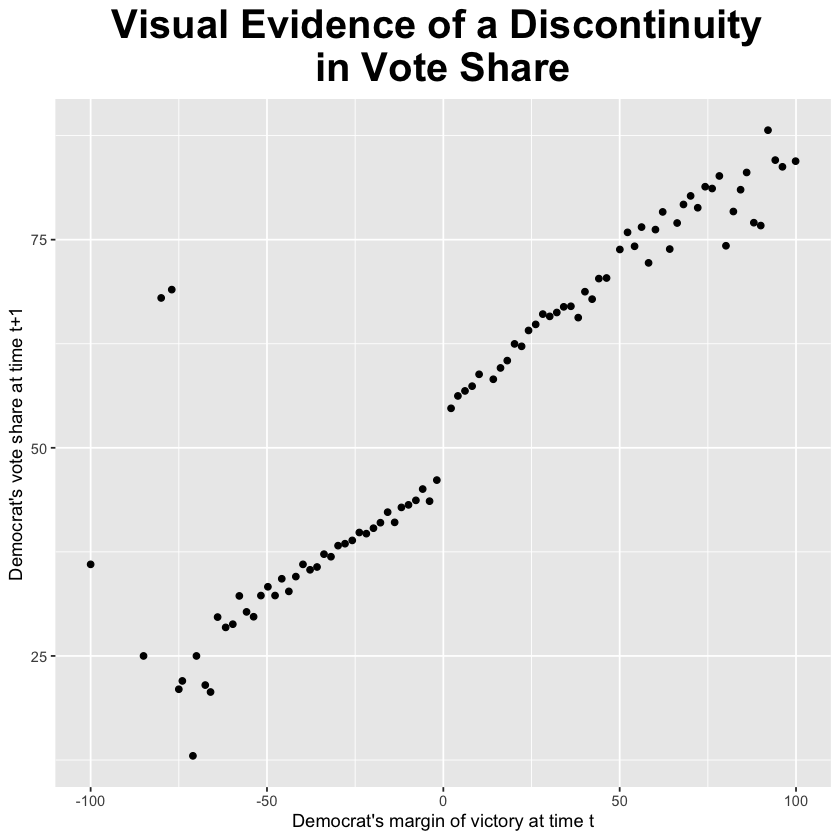

In [7]:
# Plot Democratic share at t+1 over Dem margin at t
ggplot(binned_data, aes(x = mean_margin, y = mean_dem_p1)) + geom_point() +
    ggtitle("Visual Evidence of a Discontinuity \nin Vote Share") +
  labs(x="Democrat's margin of victory at time t",y="Democrat's vote share at time t+1") +
 theme(plot.title = element_text(face="bold", size=24, hjust=0.5)) + theme(legend.position="none")

Warning message:
“Removed 3 rows containing missing values (geom_point).”

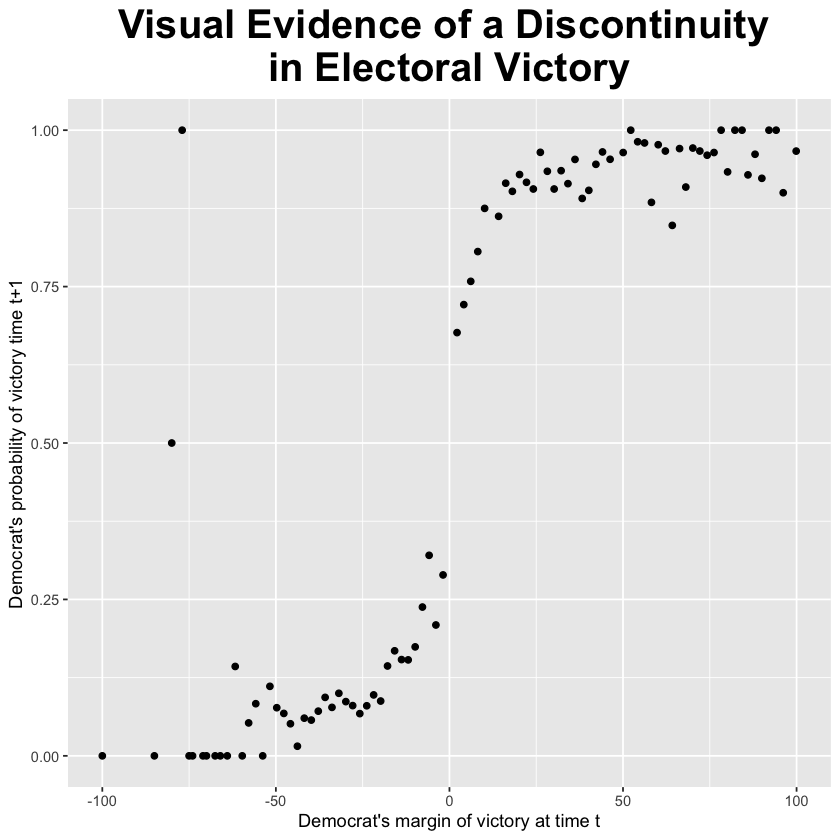

In [8]:
# Plot Democratic prob of victory at t+1 over Dem margin at t
ggplot(binned_data, aes(x = mean_margin, y = prob_dem_win_p1)) + geom_point() +
    ggtitle("Visual Evidence of a Discontinuity \nin Electoral Victory") +
  labs(x="Democrat's margin of victory at time t",y="Democrat's probability of victory time t+1") +
 theme(plot.title = element_text(face="bold", size=24, hjust=0.5)) + theme(legend.position="none")

### Regression Discontinuity Design

The two plots above give us a pretty clear picture of the incumbency advantage.  RDD is built around this discontinuity at zero and we can essentailly measure the effect here by the jump in the level of the point on the scatter plot at the cut point (i.e., a margin of victory of 0).

But if we want to be more precise, find the confidence intervals around this estimate, and control for covariates, we want to use regression analysis here.

Some notation to help describe what we are going to do:
* $Y$ is our outcome variable of interest (e.g., the probability a democrat wins the election at $t+1$). $Y(0)$ represents the outcome with no treatment and $Y(1)$ represents the outcome with treatment.
* $X$ is our running variable.  That is, this is the variable in which there is a discontinuity in the treatment (e.g., the margin of victory for a Democrat in election $t$)
* $c$ is the cut-point.  This is the point of the discontinuity in $X$ (e.g., just winning a margin of victory of 0)

In the data, we never observe $E[Y(0)|X=c]$, that is there are no units at the cutoff that don't get the treatment, but in principle it can be approximated arbitrarily well by $E[Y(0)|X=c-\varepsilon]$.  Therefore we estimate: $E[Y|X=c+\varepsilon]-E[Y|X=c-\varepsilon]$

We now need a functional form for $E[Y|X]$.  Suppose that $Y=\alpha+\tau T+ \beta f(X) +\eta$ and that $f(X)$ is a smooth function of $X$. A flexible way to do this is to modeling $f(X)$ with a pth-order polynomial in this way leads to 
$$Y=\alpha + \beta_{01}X + \beta_{02}X^{2}+...+\beta_{0p}X^{p}+\tau T + \beta_{1}TX + \beta_{2}TX^{2} + ... + \beta_{p}TX^{p}+\eta$$

We still have some choices here.  First off, what order is the polynomial we use?  Second, and relatedly, how far from the cut point do we look at the data?  

As with everything, this is a trade off.  If you look closer to the cut point, the data is more likely to be well approximated by a linear function, so you can use a lower order polynomial.  If you consider data farther from the cut point, a higher order polynomial may be necessary to fit the data better.  The distance from the cutpoint that you use in estimating the model is termed the "bandwidth" of the estimator.

There are a few formal ways to find that you have an appropriately flexible polynomial.  A couple of these are:
1. Use the Akaike information criterion (AIC) for model selection: $AIC = N ln(\hat{\sigma}^{2}) + 2p$, where $\hat{\sigma}^{2}$ is the mean squared error of the regression and $p$ is the number of model parameters (want to pick model with lowest AIC - i.e., lowest info loss)
2. Select a natural set of bins (as you would for an RD graph) and add bin dummies to the model and test their joint significance. Add higher order terms to the polynomial until the bin dummies are no longer jointly significant. (FYI, This also turns out to be a test for the presence of discontinuities in the regression function at points other then the cutoff, which you'll want to do anyway.)

There are also ways to determine that the bandwidth chosen is appropriate.  Again, this will depend on the functional form of your model.  There are two general methods for selecting bandwidth:
1. Ad hoc (e.g., elections between 48-52\% are "close") or substantively derived (Data driven)
2. Optimal bandwidth methods (Imbens and Kalyanaraman (*The Review of Economic Studies*, 2012))

A rule of thumb seems to be to use a 4th degree polynomial for $f(X)$.  But here, to make it simpler, let's start by estimating the RDD on our binned data that we just plotted using a 2nd degree polynomial and the full bandwidth (i.e., all the data).

In [9]:
# In this RD use polynomial of order 2 that varies on either side of cut point
rdd1 = lm(mean_dem_p1~mean_margin+I(mean_margin^2)+ gt0+ gt0*mean_margin+ gt0*I(mean_margin^2), data=binned_data)
summary(rdd1)


Call:
lm(formula = mean_dem_p1 ~ mean_margin + I(mean_margin^2) + gt0 + 
    gt0 * mean_margin + gt0 * I(mean_margin^2), data = binned_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-18.850  -1.394   0.278   1.480  36.344 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              49.252280   3.071888  16.033  < 2e-16 ***
mean_margin               0.595040   0.151607   3.925 0.000178 ***
I(mean_margin^2)          0.004929   0.001618   3.046 0.003110 ** 
gt0TRUE                   4.305089   4.390618   0.981 0.329679    
mean_margin:gt0TRUE      -0.146336   0.208031  -0.703 0.483755    
I(mean_margin^2):gt0TRUE -0.006364   0.002117  -3.005 0.003507 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.753 on 83 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.8968,	Adjusted R-squared:  0.8906 
F-statistic: 144.2 on 5 and 83 DF,  p-value: < 2.2e-

The coefficient on the dummy variable for the cut point is the causal effect of treatment.  In this case this is the coefficient on the `gt0` variable, which denotes a more than 50% of the vote share.  We can do the same for the probability of victory.

In [10]:
# In this RD use polynomial of order 2 that varies on either side of cut point
rdd2 = lm(prob_dem_win_p1~mean_margin+I(mean_margin^2)+ gt0+ gt0*mean_margin+ gt0*I(mean_margin^2), data=binned_data)
summary(rdd2)


Call:
lm(formula = prob_dem_win_p1 ~ mean_margin + I(mean_margin^2) + 
    gt0 + gt0 * mean_margin + gt0 * I(mean_margin^2), data = binned_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26377 -0.03611 -0.00594  0.01856  0.87584 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               2.550e-01  5.452e-02   4.677 1.11e-05 ***
mean_margin               7.682e-03  2.691e-03   2.855  0.00544 ** 
I(mean_margin^2)          7.769e-05  2.872e-05   2.705  0.00828 ** 
gt0TRUE                   5.126e-01  7.792e-02   6.579 3.98e-09 ***
mean_margin:gt0TRUE      -1.617e-03  3.692e-03  -0.438  0.66259    
I(mean_margin^2):gt0TRUE -1.222e-04  3.758e-05  -3.252  0.00166 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1198 on 83 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.9252,	Adjusted R-squared:  0.9207 
F-statistic: 205.5 on 5 and 83

We can also use `ggplot` to plot our fitted values along with the data.

Warning message:
“Removed 3 rows containing missing values (geom_point).”

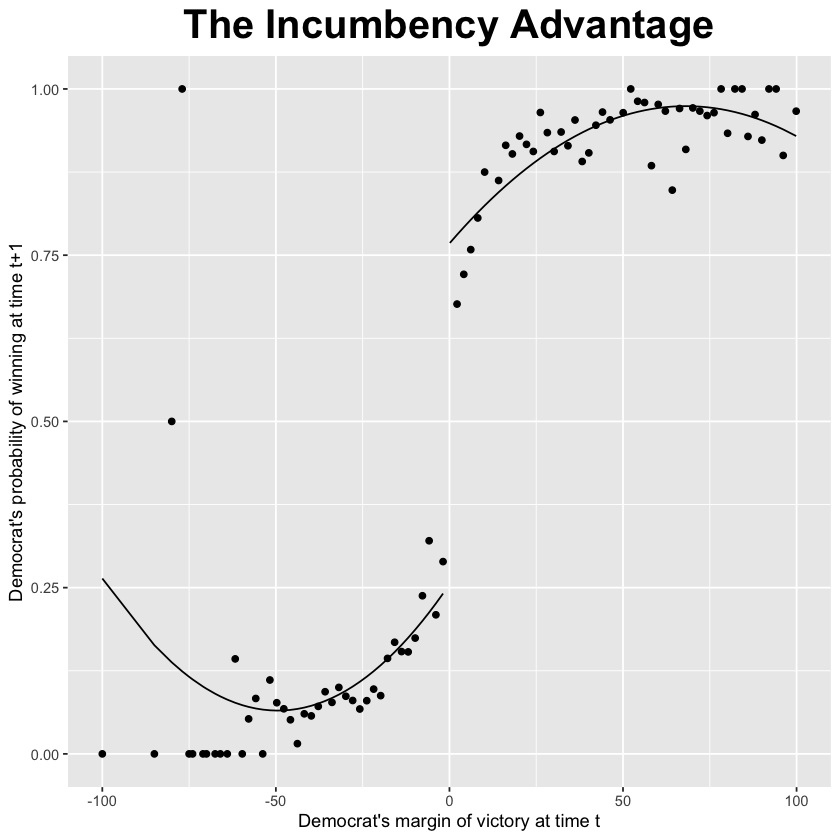

In [11]:
binned_data$myPredict <- predict(rdd2, binned_data) 
ix <- sort(binned_data$mean_margin,index.return=T)$ix

ggplot(binned_data, aes(x = mean_margin, y = prob_dem_win_p1)) + geom_point() + ggtitle("The Incumbency Advantage") +
  labs(x="Democrat's margin of victory at time t",y="Democrat's probability of winning at time t+1") +
 theme(plot.title = element_text(face="bold", size=24, hjust=0.5)) + theme(legend.position="none") +
    geom_line(color='black',data = binned_data, aes(x=mean_margin, y=myPredict, group = gt0))

### The Role of Covariates

Notice that we didn't include any other controls in the models above, such as candidate experience.  In principle, covariates are not needed for identification in RD, but they can help reduce sampling variability in the estimator and improve precision if they are correlated with the potential outcomes.  Note that this is a standard argument which also supports inclusion of covariates in analyses of randomized trials.

Adding covariates should not affect the point estimate of the effect (very much). If it does, there is likely a problem.  The wider the bandwidth the more important it may be to include covariates -  including additional covariates may eliminate some bias that is the result of the inclusion of these additional observations far from the cutoff point.

The first and most important point is that the presence of these covariates rarely changes the identification strategy. Typically, the conditional distribution of the covariates $Z$ given $X$ is continuous at $x = c$. If such discontinuities in other covariates are found, the justification of the identification strategy may be questionable. If the conditional distribution of $Z$ given $X$ is continuous at $x = c$, then including Z in the regression. 

### Threats to the Validity of the RDD

It is impossible to test the continuity assumption directly, but we can test some implications of it.  Namely, all observed predetermined characteristics should have identical distributions on either side of the cutoff, in the limit, as we approach smaller and smaller bandwidths. That is, there should be no discontinuities in the observables.

Again there is an analogy to an experiment: we cannot test whether unobserved characteristics are balanced, but we can test the observables. Rejection calls the randomization into question.

A subtle point in the RD context is that a finding a discontinuity in observable covariates indicates a violation of the continuity assumption, not a violation of unconfoundedness, which is satisfied by definition.

To make sure that our RDD is valid, we'll want to have evidence that there are not discontinuities in the covariates at the cut point - or with any pre-determined variables  E.g., we can test for discontinuities in the Democrates vote share at t-1.

Warning message:
“Removed 25 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 25 rows containing missing values (geom_point).”

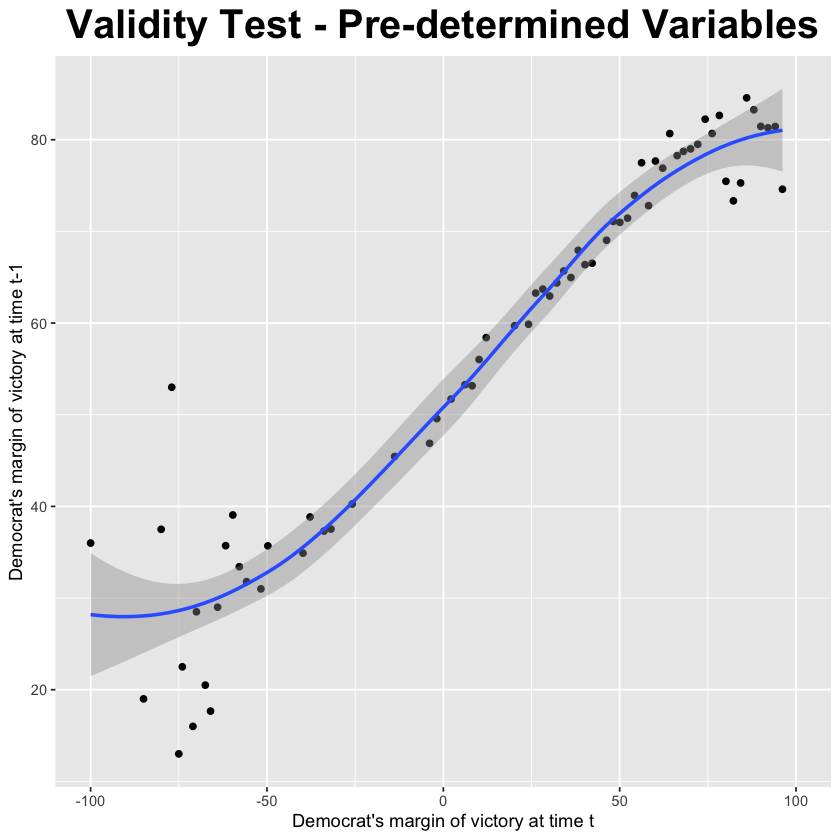

In [12]:
## Now test if other covariates smooth through cut point
ggplot(binned_data, aes(x = mean_margin, y =  mean_dem_m1)) + geom_point() +
    ggtitle("Validity Test - Pre-determined Variables") +
  labs(x="Democrat's margin of victory at time t",y="Democrat's margin of victory at time t-1") +
 theme(plot.title = element_text(face="bold", size=24, hjust=0.5)) + theme(legend.position="none") +
    stat_smooth(method = loess)

### The rdd Package

For RDD in R, on might consider the [`rdd` package](https://cran.r-project.org/web/packages/rdd/rdd.pdf).  It supports a number of different RDD estimators, will compute optimal bandwith (Imbens and Kalyanaraman (2012)), test for manipulation of the running variable (McCrary (2008)), and provides other features.

As an example, let's use the `rdd` package to find the RD estimate of the incumbency advantage on or full data:

In [13]:
# call rdd() function
library(rdd)
# default is to use IK optimal bandwidth
# In way written, using local linear regression
elec_rdd <- RDestimate(dem_win_p1~margin, data = rd_wide, cutpoint = 0)
summary(elec_rdd)


Call:
RDestimate(formula = dem_win_p1 ~ margin, data = rd_wide, cutpoint = 0)

Type:
sharp 

Estimates:
           Bandwidth  Observations  Estimate  Std. Error  z value  Pr(>|z|) 
LATE       2.116      476           0.4146    0.17446     2.377    0.0174767
Half-BW    1.058      226           0.3407    0.09131     3.731    0.0001909
Double-BW  4.232      798           0.2882    0.09080     3.174    0.0015014
              
LATE       *  
Half-BW    ***
Double-BW  ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

F-statistics:
           F        Num. DoF  Denom. DoF  p        
LATE        7.7371  3         472         9.406e-05
Half-BW     0.6089  2         223         9.103e-01
Double-BW  29.4608  3         794         0.000e+00


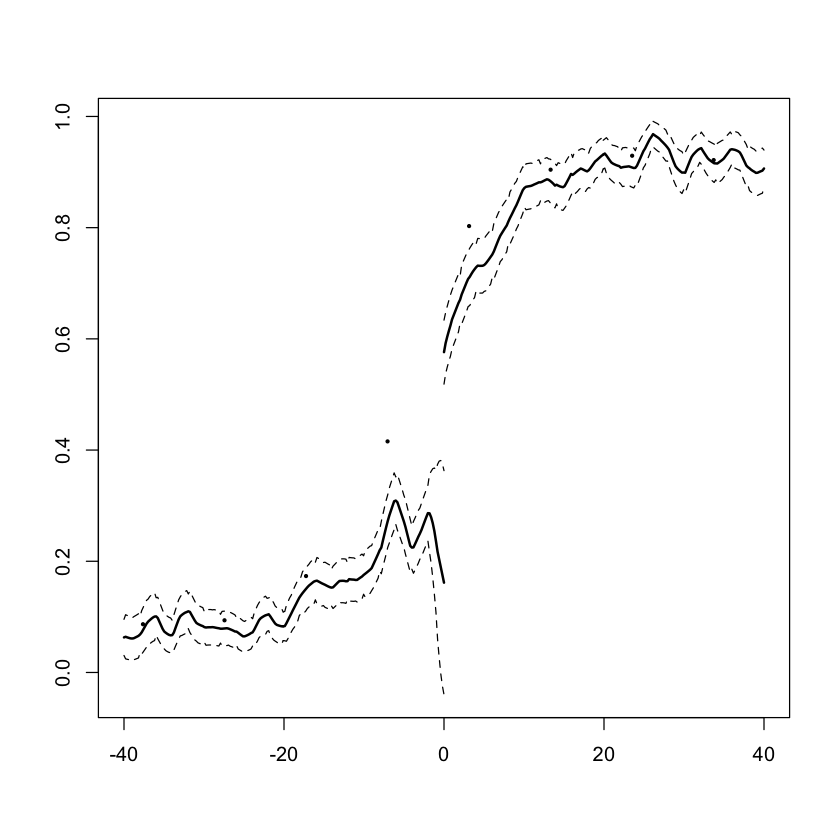

In [14]:
# quickly plot results
plot(elec_rdd, gran = 400, range = c(-40, 40))

### Summary

Lee (2008) finds incumbency advantage of 7-8% of vote share (if party won last time, this is effect), which translates to 35\% increase in prob winning.  We find effects of similar magnitude with these data - about 4-5% and 40%, repsectively.  Of course a weakness of the design (and any non-structural approach) is that it doesn't tell us anything about what drives incumbency advantage.

Also, recall that one of the main points of this paper is that RD is value even if the running variable can be endogenous - as long as it can not be perfectly chosen.  The means we can use RDD not just with elections, but also things like thresholds for test scores, etc.
